<a href="https://colab.research.google.com/github/Programmer-Mukesh/MovieRecommendor/blob/main/Collaborative_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import sklearn


In [ ]:
movies= pd.read_csv('movie.csv')
tags= pd.read_csv('tag.csv')
ratings= pd.read_csv('rating.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
movies['genres']= movies['genres'].str.replace('|',' ')

In [ ]:
len(movies.movieId.unique())

27278

In [ ]:
len(ratings.movieId.unique())

16796

In [ ]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x)>= 55)


In [ ]:
movie_list_rating = ratings_f.movieId.unique().tolist()

In [ ]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

61.30581420925287

In [ ]:
len(ratings_f.movieId.unique())/len(ratings.userId.unique()) * 100

117.97530864197532

In [ ]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
Mapping_file= dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [ ]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1,inplace=True)

Merging the movies and the tag dataframe


In [ ]:
mixed= pd.merge(movies, tags, on='movieId', how='left')
mixed.head() 

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie


In [ ]:
mixed.fillna("", inplace= True)
mixed= pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x:"%s" % ' '.join(x)))

Final= pd.merge(movies, mixed, on='movieId', how='left')
Final['metadata']= Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)

Final[['movieId','title','metadata']].head()

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...


In [ ]:
Final.shape

(16723, 5)

In [ ]:
Final.loc[1,"metadata"]

'time travel adapted from:book board game childhood recaptured game herds of CGI animals scary see also:Zathura time time travel board game fantasy Robin Williams scary time travel Robin Williams Joe Johnston Robin Williams kid flick jungle Robin Williams board game Robin Williams animals Lebbat Robin Williams time travel adventure Robin Williams Children Fantasy Robin Williams Dynamic CGI Action Kirsten Dunst Robin Williams Robin Williams fantasy kid flick animals animals fantasy For children fantasy adapted from:book childish Children kid flick time travel Joe Johnston fantasy Robin Williams time travel animals board game children fantasy Kirsten Dunst Robin Williams time travel board game time travel Children kid flick Filmed in BC fantasy Robin Williams animals bad cgi based on a book board game Chris Van Allsburg Robin Williams Robin Williams game magic board game monkey adapted from:book animals bad cgi based on a book board game childhood recaptured Children Chris Van Allsburg f

Creating a content latent matrix from movie metadeta

**tf-idf vectors and truncated SVD:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df= pd.DataFrame(tfidf_matrix.toarray(),index= Final.index.tolist())
print(tfidf_df.shape)

(16723, 22111)


In [ ]:
tfidf_df.shape

(16723, 22111)

In [ ]:
tfidf_df.loc[0]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
22106    0.0
22107    0.0
22108    0.0
22109    0.0
22110    0.0
Name: 0, Length: 22111, dtype: float64

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd= TruncatedSVD(n_components=200)
latent_matrix= svd.fit_transform(tfidf_df)
explained=svd.explained_variance_ratio_.cumsum()


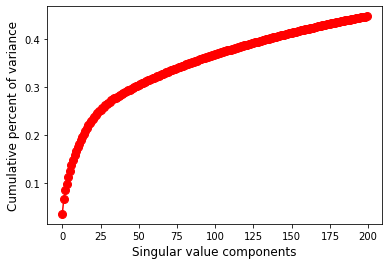

In [ ]:
plt.plot(explained,'.-', ms= 16, color='red')
plt.xlabel('Singular value components',fontsize=12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [39]:
n=200
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index= Final.title.tolist() )

In [41]:
latent_matrix.shape

(16723, 200)

In [42]:
ratings_f.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [43]:
ratings_f1= pd.merge(movies[('movieId')],ratings_f,on="movieId",how="right")

In [46]:
ratings_f2= ratings_f1.pivot(index='movieId',columns='userId',values='rating').fillna(0) 

In [47]:
ratings_f2.head(3)

userId,1,2,3,5,7,8,11,13,14,16,18,21,22,23,24,25,26,27,29,31,32,34,35,38,40,41,43,46,48,50,51,53,54,56,58,60,61,65,67,69,...,14106,14107,14108,14114,14115,14116,14117,14126,14127,14129,14130,14131,14132,14133,14138,14139,14141,14142,14143,14146,14148,14150,14151,14152,14153,14154,14155,14157,14158,14159,14160,14161,14163,14165,14166,14168,14170,14172,14173,14174
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,...,4.0,4.0,5.0,4.5,0.0,4.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,5.0,5.0,4.0,2.5,0.0,4.0,0.0,3.0,0.0,3.0,0.0,2.5,0.0,5.0,4.5,0.0,3.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,4.0,0.0,3.5
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,3.5,2.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,3.5,3.5,4.0,3.0,3.0,0.0,3.5
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0


In [48]:
ratings_f2.shape

(16723, 8278)

In [50]:
len(ratings_f.movieId.unique())

16723

In [53]:
from sklearn.decomposition import TruncatedSVD
svd= TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=Final.title.tolist())

In [56]:
latent_matrix_2_df.shape

(16723, 200)

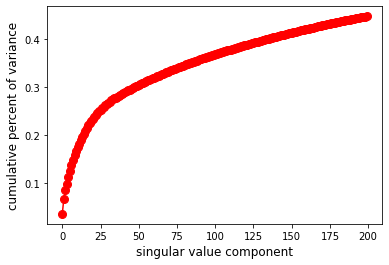

In [57]:
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('singular value component',fontsize=12)
plt.ylabel('cumulative percent of variance',fontsize=12)
plt.show()

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)
a_2 = np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1,-1)

score_1 = cosine_similarity(latent_matrix_1_df , a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)

hybrid = ((score_1 + score_2)/2.0)

dictDf = {'content':score_1, 'collaborative':score_2, 'hybrid':hybrid}
similar=pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

similar.sort_values('hybrid' , ascending= False, inplace= True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.961461,0.739183,0.850322
"Bug's Life, A (1998)",0.904780,0.656658,0.780719
"Monsters, Inc. (2001)",0.883149,0.614534,0.748841
Finding Nemo (2003),0.873704,0.595608,0.734656
"Incredibles, The (2004)",0.782484,0.565985,0.674234
Ice Age (2002),0.871477,0.461962,0.666720
Ratatouille (2007),0.895828,0.417474,0.656651
Antz (1998),0.740184,0.559371,0.649777
Toy Story 3 (2010),0.856995,0.408674,0.632835
Shrek (2001),0.584581,0.621379,0.602980
